# PDEformer-1: A Fundamental Model for One-dimensional PDEs

## Overview

### Problem Description

The dynamics of Partial Differential Equations (PDEs) are associated with a wide range of physical phenomena and engineering applications, such as wing design, electromagnetic field simulations, and stress analysis.
These real-world engineering applications all require multiple invocations of PDE solvers. Although traditional methods of solving PDEs usually exhibit high accuracy, they often require substantial computational resources and time. However, to design a universal solver for all types of PDEs could be challenging.
In recent years, the Neural Operator approach, which employs neural networks to learn data from a large number of PDE solutions to approximate the PDE operators, has significantly improved the speed of solving the forward problems of PDEs. At the same time, the trained neural network model can also serve as a differentiable surrogate model to address inverse problems.
However, current neural operator methods still struggle to generalize to new types of PDEs, and training for new PDEs often faces high training costs and difficulties in data acquisition.

To address these issues, we introduce the PDEformer model, a neural operator model that can directly input any form of PDEs.
After being trained on a large-scale dataset of one-dimensional PDEs, the PDEformer model can quickly and accurately solve any form of one-dimensional PDE forward problems, and its zero-shot prediction accuracy within the training data distribution is higher than that of any expert model trained specifically for one type of equation (such as FNO, DeepONet).
The PDEformer requires no retraining for new problems within the equation coefficient distribution and can rapidly generalize to downstream tasks through few-shot learning with minimal data for cases outside the coefficient distribution.
At the same time, the PDEformer can be directly applied to solving inverse problems.
With further increases in dataset scale, the PDEformer is expected to become a foundational model for solving various PDE problems, propelling the development of scientific research and engineering applications.

## Technical Path

We consider one-dimensional time-dependent partial differential equations (PDEs) defined on $(t,x) \in [0,1] \times [-1,1]$ with periodic boundary conditions, whose general form can be written as:

$$ \mathcal{F}(u_1,u_2,\dots,c_1,c_2,\dots,s_1(x),s_2(x),\dots)=0,$$

where $c_1,c_2,\dots \in \mathbb{R}$ are real-valued coefficients, $s_1(x),s_2(x)\dots$ are scalar functions (which can act as initial conditions, coefficient fields, etc.), and $u_1,u_2,\dots$ are the various components of the physical fields to be solved.
Here, we assume that the operator $\mathcal{F}$ has a symbolic expression, which may involve differential and algebraic operations.
The goal of PDEformer is to construct a surrogate model of the equation solution, in the form $(\mathcal{F},c_1,c_2,\dots,s_1(x),s_2(x),\dots)\mapsto (u_1,u_2,\dots)$,
which takes the symbolic form $\mathcal{F}$ of the PDE and the numerical information involved $c_1,c_2,\dots,s_1(x),s_2(x),\dots$ as inputs, and outputs the predicted solution $u_1,u_2,\dots$ for the corresponding equation.
Let's take the convection equation (single component) with periodic boundary conditions $u_t+cu_x=0$, $u(0,x)=g(x)$ as an example:

![](images/PDEformerV2Arch.png)

### Constructing the PDE Computational Graph

First, we represent $\mathcal{F}$ (the symbolic information about the PDE form to be solved) as a computational graph.
In this computational graph, a node can represent an unknown field component (denoted as `UF`), a scalar coefficient (`SC`), a coefficient field (`CF`), an initial condition (`IC`), as well as differential or algebraic operations, while a directed edge is used to specify the operands involved in an operation.
This forms a Directed Acyclic Graph (DAG) with heterogeneous nodes and homogeneous edges.

Next, to reflect the numerical information involved in the PDE, we assign a $d_e$-dimensional input feature to each node in the graph.
For a scalar coefficient $c$, its numerical value is input into a scalar encoder, and the $d_e$-dimensional output from the encoder serves as the input feature for the corresponding `SC` node.
Considering that scalar functions $s(x)$ contain relatively richer information, we introduce $N$ new "branch" nodes (of types $\mathtt{b}_1, \mathtt{b}_2, \dots, \mathtt{b}_N$) for each such scalar function, using the input features of these $N$ nodes to represent the numerical information contained in $s(x)$.
Specifically, we use a function encoder, whose input is a series of scattered points $\{(x_i,s(x_i))\}$ (the positions and distribution of points can be arbitrarily chosen), and the output $d_eN$-dimensional vector is used to provide input features for the $N$ branch nodes.
These branch nodes are connected with edges to the `IC` or `CF` vertex corresponding to $s(x)$.
The input features for all remaining nodes are set to zero (for simplification in programming implementation, actually the corresponding output when the scalar encoder receives a zero input).

Furthermore, we introduce $L$ additional nodes (of types $\mathtt{m}_1, \mathtt{m}_2, \dots, \mathtt{m}_L$) for each field component to be solved and connect them with the respective `UF` nodes.
When processing the graph data with a graph Transformer later, the information about the predicted solution for this field component will be aggregated into the embedding vectors corresponding to these new nodes.

### Encoding Graph Data

The graph data obtained in the previous step contains symbolic and numerical information involved in the PDE.
We will integrate this information from the graph data and generate a latent encoding representing the solution for each field component $u_j$ to be solved

$$\pmb{\mu}_j = [{\mu}^1_j, \dots, {\mu}^L_j]^{\mathrm{T}} \in {\mathbb{R}}^{L \times d_e}.$$

This integration process uses a graph Transformer, which is a powerful type of graph neural network based on the Transformer architecture, adept at capturing and expressing complex graph structural information.
In the implementation, we have adopted the Graphormer architecture and made some suitable adjustments for the scenarios of PDE encoding.
In the output layer of the Graph Transformer, the embedding vector corresponding to nodes of type $\mathtt{m}_\ell$ (and associated with $u_j$) is denoted as $\mu_j^\ell \in \mathbb{R}^{d_e}$, which will participate in "modulating" the $\ell$-th hidden layer of the INR in the next step to generate the final predicted solution.

### Decoding to Obtain the Predicted Solution of the PDE

We use the Implicit Neural Representation (INR) approach to represent each component of the equation solution.
This network takes the spacetime coordinates $(t,x)$ as input and predicts the value of the corresponding equation solution component $\hat u_j(t,x)$ at those coordinates based on the latent code $\pmb{\mu}_j$.
The prediction provided in this manner does not depend on a specific discretization grid.
In the implementation, we choose the Poly-INR architecture and made the corresponding adaptations (see below figure).
The number of hidden layers in the Poly-INR is $L$, where the activation values of the $\ell$-th hidden layer will be "modulated" by $\mu_j^\ell$.
Note that all components in the PDE share the same set of INR parameters; they differ only in their corresponding latent encodings $\pmb{\mu}_j$.

![](images/HyperPolyINR2.png)


### Inference Example

The example code below demonstrates how to use PDEformer to predict the solution of a given PDE. Before running, it is necessary to download the pre-trained PDEformer weights and change the value of the `model/load_ckpt` parameter in `configs/inference/pdeformer-L.yaml` to the path of the corresponding weight file.


In [1]:
import numpy as np
from mindspore import context
from mindspore import dtype as mstype
from src import load_config, get_model, PDENodesCollector, inference_pde
from src.utils.visual import plot_infer_result
from ipywidgets import interact, FloatSlider
from src import generate_plot

# basic settings
context.set_context(mode=context.PYNATIVE_MODE, device_target="CPU")
config, _ = load_config("configs/inference/pdeformer-L.yaml")
model = get_model(config, compute_type=mstype.float32)

#### Solving the Inviscid Burgers' Equation

- PDE form: $u_{t} + (\frac{1}{2}u^2)_x = 0$

- Initial condition: $u(0,x) = -\sin(\pi x)$

- Boundary condition: Periodic boundary conditions

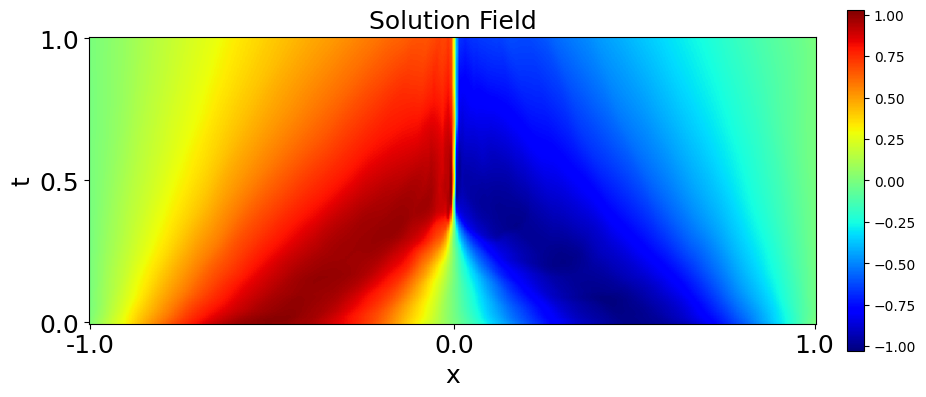

In [2]:
# define time-space coordinates
x_coord = np.linspace(-1, 1, 257)[:-1]
t_coord = np.linspace(0, 1, 101)

# solve PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, x_coord, -np.sin(np.pi * x_coord))
pde.sum_eq0(pde.dt(u), pde.dx(0.5 * pde.square(u)))

# inference and plot by PDEformer
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### Solving the Advection Equation

- PDE form: $u_{t} + \beta u_{x} = 0, \beta = 0.9$

- Initial condition: $u(0,x) = \sin(5\pi x) - \sin(2 \pi x)$

- Boundary condition: Periodic boundary conditions

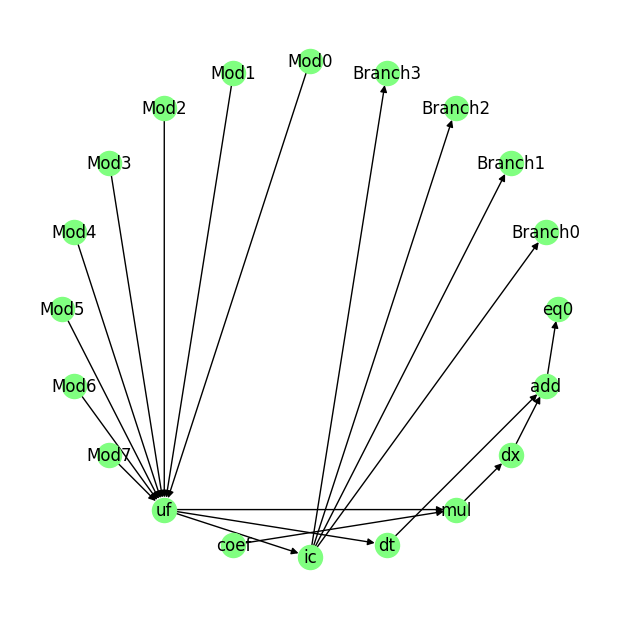

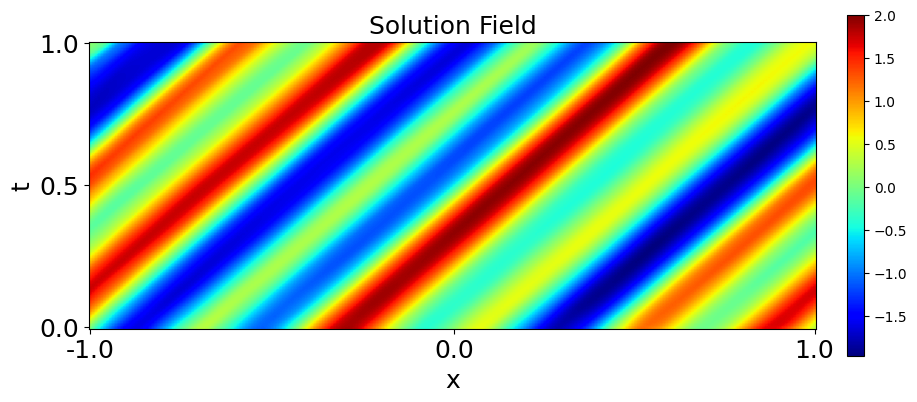

In [3]:
# solve PDE
pde = PDENodesCollector()
u = pde.new_uf()
beta = pde.new_coef(0.9)
pde.set_ic(u, x_coord, np.sin(5 * np.pi * x_coord) - np.sin(2 * np.pi * x_coord))
pde.sum_eq0(pde.dt(u), pde.dx(beta * u))

# inference and plot by PDEformer
pde_dag = pde.gen_dag(config)
pde_dag.plot()  # plot PDE computation graph
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### Solving the Viscous Burgers' Equation with Non-periodic Boundary Conditions

- PDE form: $u_{t} + (\frac{1}{2}u^2 - \kappa u_x)_x = 0$

- Initial condition: $u(0,x) = \cos(8x) + x$

- Boundary conditions: Homogeneous Dirichlet on the left ($u|_{x=-1}=0$), non-homogeneous Neumann on the right ($u_x|_{x=1}=-0.6$)

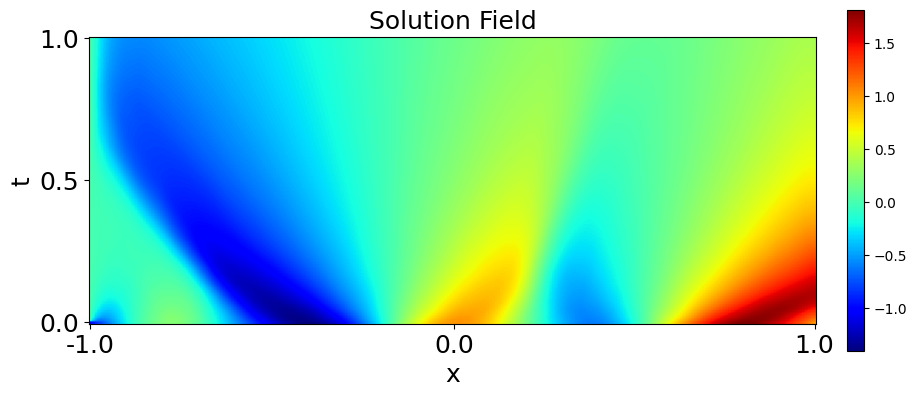

In [4]:
# solve PDE
pde = PDENodesCollector()
u = pde.new_uf()
pde.set_ic(u, x_coord, np.cos(8 * x_coord) + x_coord)
dx_u = pde.dx(u)
pde.sum_eq0(pde.dt(u), pde.dx(0.5 * pde.square(u) - 0.02 * dx_u))
pde.set_bv_l(u, 0)
pde.set_bv_r(dx_u, -0.6)

# inference and plot by PDEformer
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)

#### Solving a General Form Equation

- PDE form and initial conditions:

\begin{align}
u_t + f_0(u) + s + (f_1(u) - \kappa u_x)_x &= 0, \quad (t,x) \in [0,1] \times [-1,1], \\
f_i(u) &= c_{i1}u+c_{i2}u^2+c_{i3}u^3, \quad(i=0,1), \\
u(0,x) &= g(x), \quad x \in [-1,1]
\end{align}

In [6]:
g = -np.sin(2 * np.pi * x_coord)

def interactive_plot(c_01, c_02, c_03, c_11, c_12, c_13, kappa, source):
    generate_plot(model, config, g, x_coord, t_coord,
                  [c_01, c_02, c_03, c_11, c_12, c_13], kappa, source)

interact(interactive_plot,
         c_01=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_02=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_03=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_11=FloatSlider(value=0, min=-3, max=3, step=0.01),
         c_12=FloatSlider(value=0.5, min=-3, max=3, step=0.01),
         c_13=FloatSlider(value=0, min=-3, max=3, step=0.01),
         kappa=FloatSlider(value=0.0, min=0, max=1, step=0.001),
         source=FloatSlider(value=0, min=-3, max=3, step=0.01))

interactive(children=(FloatSlider(value=0.0, description='c_01', max=3.0, min=-3.0, step=0.01), FloatSlider(va…

<function __main__.interactive_plot(c_01, c_02, c_03, c_11, c_12, c_13, kappa, source)>

#### Solving the Non-periodic Boundary Wave Equation

- PDE form: $u_{tt} + c(x)^2 u_{xx} = 0$

- Velocity field: $c(x) = 1.1 - e^{-8x^2}$

- Initial conditions: $u(0,x) = \sin(\pi x)\cos(8x)$, $u_t(0,x) = 0$

- Boundary conditions: Non-homogeneous Robin on the left $(-0.6u + 0.8u_x)|_{x=-1} = 0.1$, Mur on the right $(u_t + c(1)u_x)|_{x=1} = 0$

- Remember to load the checkpoint finetuned on the wave equation dataset.

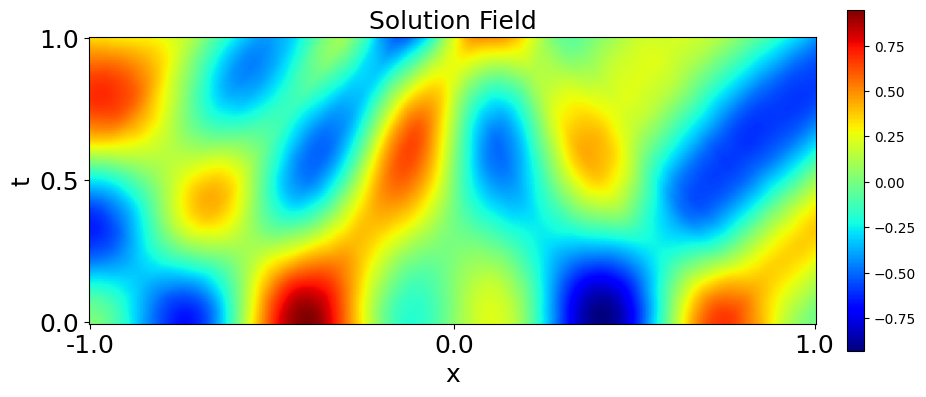

In [5]:
pde = PDENodesCollector()
u = pde.new_uf()

# initial condition
pde.set_ic(u, x_coord, np.sin(np.pi * x_coord) * np.cos(8 * x_coord))
pde.set_ic(u.dt, x_coord, 0 * x_coord)

# velocity field and boundary conditions
c_arr = 1.1 - np.exp(-8 * x_coord**2)
pde.set_bv_l(0.8 * u.dx + (-0.6) * u, 0.1)
pde.set_bv_r(u.dt + c_arr[-1] * u.dx, 0)

# main PDE
c2 = pde.new_coef_field(x_coord, c_arr**2)
pde.sum_eq0(u.dt.dt, c2 * u.dx.dx)

# inference and plot by PDEformer
pde_dag = pde.gen_dag(config)
u_pred = inference_pde(model, pde_dag, t_coord, x_coord)
plot_infer_result(u_pred, x_coord, t_coord)